In [1]:
import helper
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


### Train a DNN on the modified dataset

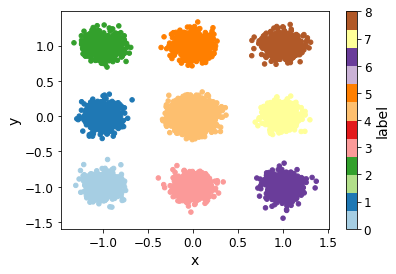

Train Size: (4500, 2)
Test Size: (500,)
Categories: [array([0, 1])]


In [2]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=5000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [3]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [5]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [11]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=10)

Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 0s 96us/step - loss: 0.1825 - acc: 0.9878 - val_loss: 0.0551 - val_acc: 1.0000
Epoch 2/50
4500/4500 [==============================] - 0s 63us/step - loss: 0.0337 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 3/50
4500/4500 [==============================] - 0s 66us/step - loss: 0.0164 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 1.0000
Epoch 4/50
4500/4500 [==============================] - 0s 65us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 5/50
4500/4500 [==============================] - 0s 64us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 6/50
4500/4500 [==============================] - 0s 63us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 7/50
4500/4500 [==============================] - 0s 66us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 8/

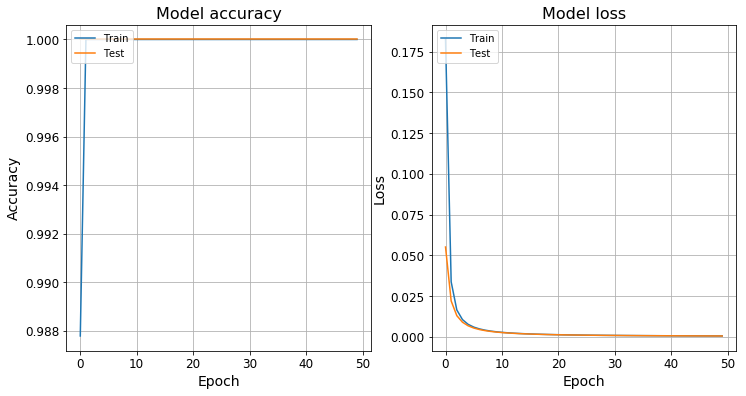

In [12]:
# Plotting results from history
plot_history(history)

In [13]:
preds = [x for x in nn.predict(Zscaler.transform(X_test[:5]))]
_labels = [np.float(x) for x in y_test]
preds[:5],_labels[:5]

([array([2.1252938e-04, 9.9978751e-01], dtype=float32),
  array([3.6709433e-04, 9.9963284e-01], dtype=float32),
  array([4.2494436e-04, 9.9957508e-01], dtype=float32),
  array([9.993838e-01, 6.161342e-04], dtype=float32),
  array([1.5865815e-04, 9.9984133e-01], dtype=float32)],
 [1.0, 1.0, 1.0, 0.0, 1.0])

## Performing LRP

In [14]:
import innvestigate
import innvestigate.utils as iutils

plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": "Set1", "s":10, "alpha":0.25}

def perform_analysis(model, analyzer, data, labels=[]):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    df_anal = pd.DataFrame(analysis)
    
    return df_anal


scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
# lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)

all_lrp_E = perform_analysis(model,lrp_E, all_samples)

Prediction Accuracy
5000/5000 [==============================] - 0s 8us/step
Scores on data set: loss=0.001 accuracy=1.0000


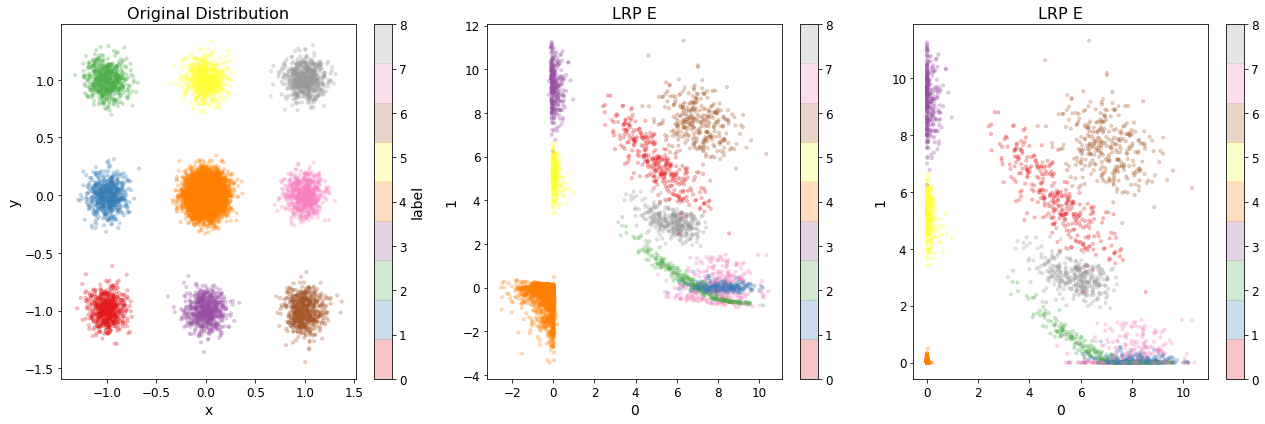

In [15]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

plot_args["c"] = "label"
original_data.plot(ax=axs[0], title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()